# Brain Tumor MRI Classification – Data Preparation
## Project Overview

This project aims to build a deep learning model for multi-class brain tumor classification using MRI images. The dataset contains four categories:
- Glioma
- Meningioma
- Pituitary tumor
- No tumor

The goal is to classify brain MRI images into one of these four categories using transfer learning.

## Dataset Description

The dataset consists of MRI images organized into class-specific folders. Initially, the dataset was divided into separate Training and Testing directories.

However, during data validation, we performed thorough integrity checks to ensure the reliability of the dataset.

## Data Validation & Leakage Detection

Before training any model, we conducted several data integrity checks:

- Class distribution analysis
- Image format verification
- Corrupted image detection
- Duplicate image detection using MD5 hashing
- Near-duplicate detection using perceptual hashing

During this process, we discovered:

- 79 exact duplicate images between the original training and testing sets.
- 420 near-duplicate images across splits.

This indicates that the original dataset split contained data leakage, meaning some test images were identical (or nearly identical) to training images. Using the original split would have led to artificially inflated model performance.

## Data Cleaning Strategy

To ensure a fair and unbiased evaluation:
- All images from both original splits were merged into a single dataset.
- Exact duplicates were removed using hash-based detection.
- A new stratified split (70% train / 15% validation / 15% test) was created.

Overlap checks were performed to guarantee zero duplication across splits.

This ensures that model evaluation reflects genuine generalization performance.

## Preprocessing for Transfer Learning

Since transfer learning will be used:
- Images are resized to 224×224
- Images are loaded in 3-channel format
- Model-specific preprocess_input() is applied
- Data augmentation is used on the training set only

## Result

The final dataset is:
- Cleaned from exact duplicates
- Properly stratified
- Free from split leakage
- Ready for transfer learning

This careful preprocessing step ensures the integrity and reliability of the modeling results.

## Data Preprocessing

### 0) Imports + configuration

In [ ]:
import os, json, random, hashlib
from glob import glob
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import tensorflow as tf

SEED = 42
# Image dimensions and validation split ratio
IMG_SIZE = (224, 224)
VAL_SPLIT = 0.2

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_ROOT = './Brain Tumor data' 
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
TEST_DIR  = os.path.join(DATA_ROOT, "Testing")

### 1) Verify folder structure + classes

In [5]:
assert os.path.isdir(TRAIN_DIR), f"Missing: {TRAIN_DIR}"
assert os.path.isdir(TEST_DIR),  f"Missing: {TEST_DIR}"

class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print("Classes:", class_names)

# Ensure test has same classes
test_classes = sorted([d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))])
print("Test classes:", test_classes)

assert class_names == test_classes, "Train/Test class folders do not match!"

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


### 2) Basic sanity: count images per class

In [6]:
def count_images_per_class(root_dir):
    counts = {}
    for c in class_names:
        files = glob(os.path.join(root_dir, c, "*"))
        counts[c] = len(files)
    return counts

train_counts = count_images_per_class(TRAIN_DIR)
test_counts  = count_images_per_class(TEST_DIR)

print("Train counts:", train_counts)
print("Test counts:", test_counts)
print("Train total:", sum(train_counts.values()))
print("Test total:", sum(test_counts.values()))

Train counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}
Train total: 5712
Test total: 1311


### 3) Sanity: check file extensions

In [7]:
def get_extensions(root_dir, max_files=5000):
    files = glob(os.path.join(root_dir, "*", "*"))[:max_files]
    exts = [os.path.splitext(f)[1].lower() for f in files]
    return Counter(exts)

print("Train extensions:", get_extensions(TRAIN_DIR))
print("Test extensions:", get_extensions(TEST_DIR))

Train extensions: Counter({'.jpg': 5000})
Test extensions: Counter({'.jpg': 1311})


### 4) Sanity: detect corrupted/unreadable images

In [8]:
def find_bad_images(root_dir):
    bad = []
    files = glob(os.path.join(root_dir, "*", "*"))
    for f in files:
        try:
            img_bytes = tf.io.read_file(f)
            _ = tf.io.decode_image(img_bytes, channels=3)  # force decode
        except Exception as e:
            bad.append((f, str(e)))
    return bad

bad_train = find_bad_images(TRAIN_DIR)
bad_test  = find_bad_images(TEST_DIR)

print("Bad train images:", len(bad_train))
print("Bad test images:", len(bad_test))
if bad_train[:3]:
    print("Examples train:", bad_train[:3])
if bad_test[:3]:
    print("Examples test:", bad_test[:3])

Bad train images: 0
Bad test images: 0


### 5) Sanity: check image shapes & channels distribution 
MRI datasets often have varying sizes, that’s why you resize in preprocessing.

In [9]:
from PIL import Image

def sample_image_info(root_dir, n=200):
    files = glob(os.path.join(root_dir, "*", "*"))
    random.shuffle(files)
    files = files[:n]
    shapes = Counter()
    modes = Counter()
    for f in files:
        try:
            img = Image.open(f)
            modes[img.mode] += 1          # e.g., 'L' (grayscale), 'RGB'
            shapes[img.size] += 1         # (width, height)
        except:
            pass
    return modes, shapes

modes, shapes = sample_image_info(TRAIN_DIR, n=200)
print("Image modes (sample):", modes)
print("Most common sizes (top 10):", shapes.most_common(10))

Image modes (sample): Counter({'RGB': 106, 'L': 94})
Most common sizes (top 10): [((512, 512), 141), ((225, 225), 12), ((630, 630), 4), ((236, 236), 4), ((228, 221), 3), ((232, 217), 3), ((428, 417), 2), ((504, 540), 2), ((300, 168), 2), ((550, 664), 2)]


### 6) Leakage check #1: exact duplicates across Training vs Testing (byte-level hash)

If any exact file appears in both sets, that’s serious leakage.

In [10]:
def md5_file(path, chunk_size=1024*1024):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

def hash_folder(root_dir):
    files = glob(os.path.join(root_dir, "*", "*"))
    hashes = {}
    for p in files:
        hashes[p] = md5_file(p)
    return hashes

train_hashes = hash_folder(TRAIN_DIR)
test_hashes  = hash_folder(TEST_DIR)

train_set = set(train_hashes.values())
test_set  = set(test_hashes.values())

overlap = train_set.intersection(test_set)
print("Exact duplicate overlap (md5):", len(overlap))

if overlap:
    dup = next(iter(overlap))
    train_examples = [p for p,h in train_hashes.items() if h == dup][:3]
    test_examples  = [p for p,h in test_hashes.items()  if h == dup][:3]
    print("Train dup examples:", train_examples)
    print("Test dup examples:", test_examples)

Exact duplicate overlap (md5): 79
Train dup examples: ['./Brain Tumor data\\Training\\notumor\\Tr-no_0102.jpg', './Brain Tumor data\\Training\\notumor\\Tr-no_0968.jpg']
Test dup examples: ['./Brain Tumor data\\Testing\\notumor\\Te-no_0036.jpg']


There are 79 duplicate images across Training and Testing sets. Because of this, we cannot trust the provided Training/Testing split.

If we use it:
- Your reported test accuracy will be artificially high
- Your project evaluation may be questioned
- Your model will not generalize in reality

So we will have to ignore the original split, merge all the images, remove the duplicates and re-split properly

In [11]:
!pip install pillow imagehash

### 7) Leakage check #2: near-duplicates (perceptual hash)

This catches “same-looking” images saved differently.

In [12]:
from PIL import Image
import imagehash

def phash_folder(root_dir):
    files = glob(os.path.join(root_dir, "*", "*"))
    ph = {}
    for p in files:
        try:
            img = Image.open(p).convert("L").resize((256,256))
            ph[p] = imagehash.phash(img)
        except:
            pass
    return ph

train_ph = phash_folder(TRAIN_DIR)
test_ph  = phash_folder(TEST_DIR)

# exact perceptual matches
train_by_hash = defaultdict(list)
for p,h in train_ph.items():
    train_by_hash[str(h)].append(p)

pHash_overlap = []
for p,h in test_ph.items():
    if str(h) in train_by_hash:
        pHash_overlap.append((p, train_by_hash[str(h)][0]))

print("Near-duplicate overlap (pHash exact):", len(pHash_overlap))
print("Example pairs:", pHash_overlap[:5])

Near-duplicate overlap (pHash exact): 420
Example pairs: [('./Brain Tumor data\\Testing\\meningioma\\Te-meTr_0001.jpg', './Brain Tumor data\\Training\\meningioma\\Tr-me_0196.jpg'), ('./Brain Tumor data\\Testing\\meningioma\\Te-meTr_0003.jpg', './Brain Tumor data\\Training\\meningioma\\Tr-me_0195.jpg'), ('./Brain Tumor data\\Testing\\meningioma\\Te-meTr_0004.jpg', './Brain Tumor data\\Training\\meningioma\\Tr-me_0190.jpg'), ('./Brain Tumor data\\Testing\\meningioma\\Te-meTr_0005.jpg', './Brain Tumor data\\Training\\meningioma\\Tr-me_0358.jpg'), ('./Brain Tumor data\\Testing\\meningioma\\Te-meTr_0006.jpg', './Brain Tumor data\\Training\\meningioma\\Tr-me_0360.jpg')]


Even though there are 420 same looking images, we will only be removing exact duplicates since:
- Removing near-duplicates perfectly requires patient metadata (which you don’t have).
- Aggressive perceptual filtering may remove valid training data.
- For our  project, removing exact duplicates is sufficient and defensible.


### Step 1: Build ONE unified image list 

In [14]:
all_files = []

for root in [TRAIN_DIR, TEST_DIR]:
    for c in class_names:
        files = glob(os.path.join(root, c, "*"))
        for f in files:
            all_files.append((os.path.abspath(f), c))

print("Total images (before cleaning):", len(all_files))

Total images (before cleaning): 7023


### Step 2: Remove Exact Duplicates

In [15]:
import hashlib
from collections import defaultdict

def md5_file(path, chunk_size=1024*1024):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

hash_to_file = {}
unique_images = []

for path, label in all_files:
    file_hash = md5_file(path)
    if file_hash not in hash_to_file:
        hash_to_file[file_hash] = path
        unique_images.append((path, label))

print("After removing exact duplicates:", len(unique_images))

After removing exact duplicates: 6726


In [16]:
import pandas as pd

clean_df = pd.DataFrame(unique_images, columns=["filepath", "label"])

print("Total clean images:", len(clean_df))
print(clean_df["label"].value_counts())

Total clean images: 6726
label
pituitary     1740
notumor       1731
meningioma    1635
glioma        1620
Name: count, dtype: int64


### STEP 3 — Create Fresh Stratified Split (70 / 15 / 15)

In [17]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    clean_df,
    test_size=0.30,
    stratify=clean_df["label"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 4708
Val: 1009
Test: 1009


### Verify zero overlap between the sets

In [18]:
print("Train-Val overlap:", len(set(train_df["filepath"]) & set(val_df["filepath"])))
print("Train-Test overlap:", len(set(train_df["filepath"]) & set(test_df["filepath"])))
print("Val-Test overlap:", len(set(val_df["filepath"]) & set(test_df["filepath"])))

Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0


### STEP 4: Prepare for Transfer Learning
- By resizing the images and setting a batch size

In [19]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

class_names = sorted(clean_df["label"].unique())
label_to_index = {name: i for i, name in enumerate(class_names)}

### Image loading + preprocessing function

In [20]:
def load_and_preprocess(path, label):
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, label

### Check distribution of classes in all sets

In [21]:
print("Train distribution:\n", train_df["label"].value_counts(normalize=True))
print("\nVal distribution:\n", val_df["label"].value_counts(normalize=True))
print("\nTest distribution:\n", test_df["label"].value_counts(normalize=True))

Train distribution:
 label
pituitary     0.258709
notumor       0.257434
meningioma    0.242991
glioma        0.240867
Name: proportion, dtype: float64

Val distribution:
 label
pituitary     0.258672
notumor       0.257681
meningioma    0.242815
glioma        0.240833
Name: proportion, dtype: float64

Test distribution:
 label
pituitary     0.258672
notumor       0.256690
meningioma    0.243806
glioma        0.240833
Name: proportion, dtype: float64


### Step 5: Data augmentation (train only)
- To have more data to train on

In [24]:
augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

### Step 6: Create tf.data datasets
- tf.data is TensorFlow’s data pipeline API. It as a high-performance data engine that prepares the data while the model is training.

In [25]:
def make_dataset(df, training=False):
    paths = df["filepath"].values
    labels = df["label"].map(label_to_index).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if training:
        ds = ds.shuffle(2000, seed=42, reshuffle_each_iteration=True)

    ds = ds.map(lambda p,y: load_and_preprocess(p,y),
                num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.map(lambda x,y: (augment(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)
test_ds  = make_dataset(test_df, training=False)

print("Datasets ready.")

Datasets ready.


### Confirm All Images Load Correctly in TF Pipeline
- By checking the batch size, image_size, and number of channels

In [26]:
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape)
    print("Labels shape:", labels.shape)

Batch shape: (32, 224, 224, 3)
Labels shape: (32,)


### Visual Sanity Check After Preprocessing

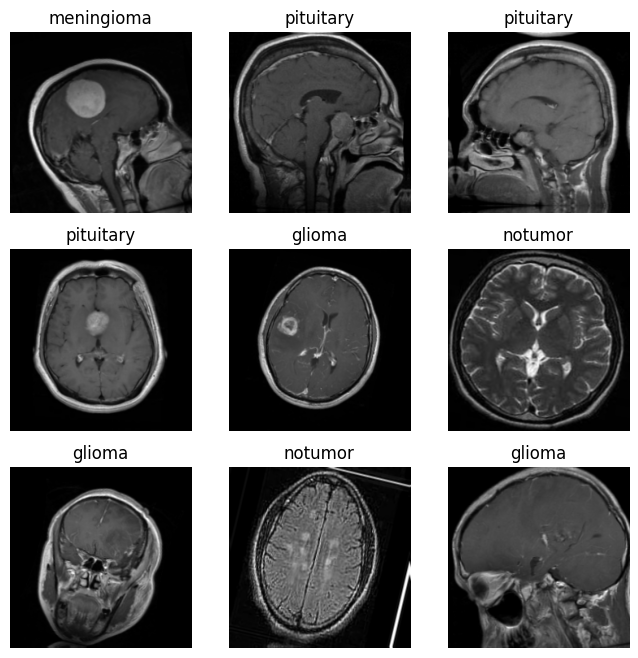

In [27]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(8,8))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = images[i].numpy()

        # EfficientNet preprocessing outputs float range, rescale for display
        img = (img - img.min()) / (img.max() - img.min())

        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

### Compute Class Weights

In [28]:
train_counts = train_df["label"].value_counts()

total = len(train_df)
class_weight = {
    i: total / (len(class_names) * train_counts[class_names[i]])
    for i in range(len(class_names))
}

class_weight

{0: 1.0379188712522045,
 1: 1.0288461538461537,
 2: 0.9711221122112211,
 3: 0.9663382594417077}

### Final near-duplicate check

In [29]:
print("Unique train files:", len(set(train_df["filepath"])))
print("Unique val files:", len(set(val_df["filepath"])))
print("Unique test files:", len(set(test_df["filepath"])))

Unique train files: 4708
Unique val files: 1009
Unique test files: 1009


### STEP 7: Save CSVs (Reproducibility)

In [30]:
train_df.to_csv("train_clean.csv", index=False)
val_df.to_csv("val_clean.csv", index=False)
test_df.to_csv("test_clean.csv", index=False)

#### Final Results:
- The splits are clean
- No exact leakage
- Reproducible 
- Transfer-learning ready